In [1]:
from src.space_exploration.metrics.clusterability.spatial_histogram import measure_spatial_histogram 
from src.space_exploration.metrics.clusterability.hopkins import measure_hopkins
from src.space_exploration.metrics.clusterability.clustering_validation import clustering_measures, METRICS
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
from typing import Union
from gensim.models.keyedvectors import KeyedVectors
from textfab import Conveyer, see_available_units
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans
from tqdm.auto import tqdm

In [2]:
from typing import List
import numpy as np
import math
import copy

class SentenceEncoder:
    def __init__(self, static_embeddings: KeyedVectors,):
        self.embs = static_embeddings
        self.dim = static_embeddings.vectors.shape[1]

    
    def encode(self, tokens: List[str], mode='pass'):
        sent_emb = []
        for t in tokens:
            if t in self.embs:
                sent_emb.append(self.embs[t])
            else:
                if mode == "pass":
                    continue
                elif mode == "random":
                    sent_emb.append(np.random.rand(1, self.dim))
        return np.mean(np.vstack(sent_emb), axis=0)
    
    def encode_list(self, texts: List[List[str]], mode='pass'):
        embs = []
        for t in texts:
            embs.append(self.encode(t, mode))
        return np.vstack(embs)


def plot_radar_diagram(data: List[List[Union[int, float]]], names: List[str], categories: List[str]):
    """https://www.python-graph-gallery.com/391-radar-chart-with-several-individuals"""
    N = len(categories)
    data_ = copy.deepcopy(data)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the spider plot
    plt.figure(figsize=(10,15))
    ax = plt.subplot(111, polar=True)
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories)
    
    # Draw ylabels
    #int_y_max = int(math.ceil(max([d[-1] for d in data]) * 10)) #int(math.ceil(max([d[-1] for d in data]) * 10) / 10)
    #print(int_y_max)
    ax.set_rlabel_position(0)
    #plt.yticks([0.1*i for i in range(1, int_y_max)],  color="grey", size=7)
    #plt.ylim(0, int_y_max/10)

    for d, n in zip(data_, names):
        values = d
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=n)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

In [3]:
vecs_50 = KeyedVectors.load_word2vec_format("/media/astromis/Data/Embeddings/glove.6B.50d.txt", binary=False, no_header=True)
vecs_100 = KeyedVectors.load_word2vec_format("/media/astromis/Data/Embeddings/glove.6B.100d.txt", binary=False, no_header=True)
vecs_200 = KeyedVectors.load_word2vec_format("/media/astromis/Data/Embeddings/glove.6B.200d.txt", binary=False, no_header=True)
vecs_300 = KeyedVectors.load_word2vec_format("/media/astromis/Data/Embeddings/glove.6B.300d.txt", binary=False, no_header=True)

In [4]:
encoder_50 = SentenceEncoder(vecs_50)
encoder_100 = SentenceEncoder(vecs_100)
encoder_200 = SentenceEncoder(vecs_200)
encoder_300 = SentenceEncoder(vecs_300)

preproc = Conveyer(["lower_string", "remove_punct", "swap_enter_to_space", "collapse_spaces", "tokenize_with_nltk"])

In [5]:
dataset = fetch_20newsgroups()
texts, labels = dataset["data"], dataset["target"]

In [6]:
texts_pr = preproc.start(texts)

In [7]:
experiments = [(encoder_50, "pass"), (encoder_50, "random"), 
              (encoder_100, "pass"), (encoder_100, "random"),
              (encoder_200, "pass"), (encoder_200, "random"),
              (encoder_300, "pass"), (encoder_300, "random")]

In [8]:
res = []
names=[]
hopkins = []
spatial_hist = []
embeddings = []

for encoder, mode in tqdm(experiments):
    name = f"encoder_{encoder.dim}_{mode}"
    print(name)
    text_vectors = encoder.encode_list(texts_pr, mode)
    
    hopkins.append(measure_hopkins(text_vectors))
    spatial_hist.append(measure_spatial_histogram(text_vectors))

    clusts_embs = KMeans(init='k-means++', n_clusters=20, n_init=20, random_state = 21)
    clusts_embs_texts = clusts_embs.fit(np.vstack(text_vectors))
    km_embs_meas = clustering_measures(labels, clusts_embs_texts.labels_)
    res.append(list(km_embs_meas.values()))
    names.append(name)
    embeddings.append((text_vectors, name))

  0%|          | 0/8 [00:00<?, ?it/s]

encoder_50_pass
1.0


100%|██████████| 50/50 [00:10<00:00,  4.68it/s]


Spatial histogram:  Mu: 2.6360043489770844, sigma: 0.03541888468192329
encoder_50_random
1.0


100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


Spatial histogram:  Mu: 3.219893106959157, sigma: 0.05468775796653601
encoder_100_pass
1.0


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


Spatial histogram:  Mu: 2.608309516864356, sigma: 0.03947032502072523
encoder_100_random
1.0


100%|██████████| 50/50 [00:10<00:00,  4.90it/s]


Spatial histogram:  Mu: 3.794541223114938, sigma: 0.06106031523286504
encoder_200_pass
1.0


100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


Spatial histogram:  Mu: 2.5952841538124303, sigma: 0.03677462363282747
encoder_200_random
1.0


100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


Spatial histogram:  Mu: 4.55398131872158, sigma: 0.08322439532676973
encoder_300_pass
1.0


100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


Spatial histogram:  Mu: 2.6213965953476133, sigma: 0.034466784916161806
encoder_300_random
1.0


100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


Spatial histogram:  Mu: 4.743056849184239, sigma: 0.07486630677163694


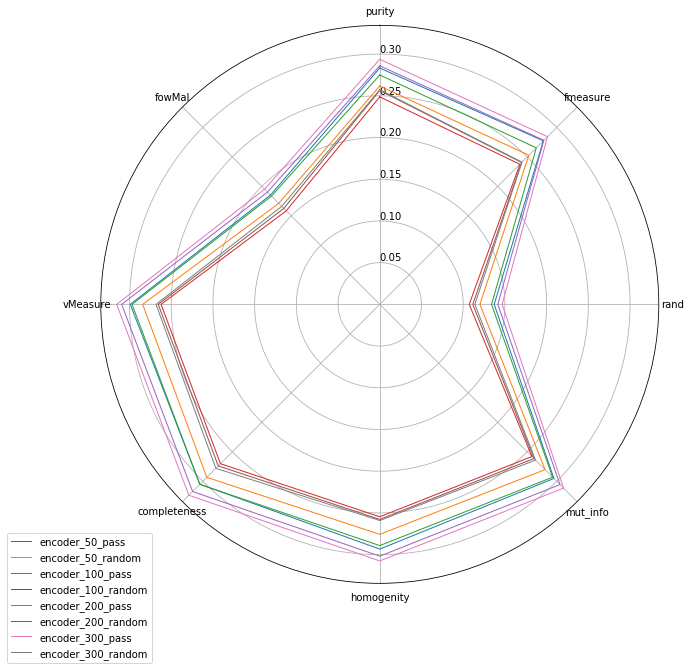

In [9]:
plot_radar_diagram(res, names, METRICS)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

def test_model(model_class, data, label, n_iter, kwargs):
    metric_res = []
    for _ in range(n_iter):
        x_train, x_test, y_train, y_test = train_test_split(data, labels)
        model = model_class(**kwargs)
        model.fit(x_train, y_train)
        metric_res.append(f1_score(y_test, model.predict(x_test), average="macro"))
    return np.mean(metric_res), np.std(metric_res)

In [11]:
model_settings = [("LogReg", LogisticRegression, {"max_iter":1000}), ("LinerSVM", LinearSVC, {}), ("KNN", KNeighborsClassifier, {})]

In [12]:
overall = []
for emd, name in tqdm(embeddings):
    for model_name, model_cl, params in tqdm(model_settings, leave=False):
        metric_mean, metric_std = test_model(model_cl, emd, labels, 5, params)
        overall.append( (name, model_name, metric_mean, metric_std) )

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/home/astromis/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/astromis/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/astromis/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/home/astromis/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/astromis/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/astromis/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/astromis/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/astromis/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [13]:
import pandas as pd

In [26]:
df = pd.DataFrame(overall, columns=('encoder', "model", "metric_mean", "metric_std"))

In [27]:
df.pivot(index="encoder", columns="model", )

metric_mean                     metric_std            \
model                      KNN  LinerSVM    LogReg        KNN  LinerSVM   
encoder                                                                   
encoder_100_pass      0.628311  0.683171  0.683690   0.006046  0.003846   
encoder_100_random    0.609017  0.687487  0.674162   0.010760  0.002838   
encoder_200_pass      0.669182  0.733576  0.718857   0.007801  0.005830   
encoder_200_random    0.646545  0.731054  0.719960   0.012713  0.005042   
encoder_300_pass      0.689221  0.767670  0.742413   0.009682  0.004501   
encoder_300_random    0.635617  0.766459  0.728663   0.007573  0.004219   
encoder_50_pass       0.589541  0.598509  0.609704   0.008757  0.003489   
encoder_50_random     0.582306  0.604772  0.611844   0.008112  0.006490   

                              
model                 LogReg  
encoder                       
encoder_100_pass    0.004819  
encoder_100_random  0.003791  
encoder_200_pass    0.005274  
encoder_200_random  0.007606  
encoder_300_pass    0.003868  
encoder_300_random  0.009474  
encoder_50_pass     0.007384  
encoder_50_random   0.008797

In [29]:
encoder_names = [f"encoder_{e.dim}_{m}" for e, m in experiments]
spatial_hist_mean = [x[1] for x in spatial_hist] 

In [40]:
pd.DataFrame(zip(encoder_names, spatial_hist_mean), columns=["encoder", "spatial_hist_mean"])

,encoder,spatial_hist_mean
0,encoder_50_pass,2.636004
1,encoder_50_random,3.219893
2,encoder_100_pass,2.608310
3,encoder_100_random,3.794541
4,encoder_200_pass,2.595284
5,encoder_200_random,4.553981
6,encoder_300_pass,2.621397
7,encoder_300_random,4.743057
